# **Step 1: Install and Import Required Libraries**

In [4]:
!pip install requests pandas tqdm


In [5]:
import requests
import pandas as pd
from tqdm import tqdm


# **Step 2: Load Wallets URL**

In [6]:
wallets_url = 'https://docs.google.com/spreadsheets/d/1ZzaeMgNYnxvriYYpe8PE7uMEblTI0GV5GIVUnsP-sBs/export?format=csv'
wallet_df = pd.read_csv(wallets_url)
wallets = wallet_df.iloc[:, 0].tolist()
wallets[:5]  # show first 5

['0x0039f22efb07a647557c7c5d17854cfd6d489ef3',
 '0x06b51c6882b27cb05e712185531c1f74996dd988',
 '0x0795732aacc448030ef374374eaae57d2965c16c',
 '0x0aaa79f1a86bc8136cd0d1ca0d51964f4e3766f9',
 '0x0fe383e5abc200055a7f391f94a5f5d1f844b9ae']

# **Step 3: Fetch Compound V2 Transaction Data (Via DeFiLlama Adapter or Etherscan-like API)**

Since Compound doesn’t offer a simple wallet-based API, we'll use DeFiLlama’s protocol adapter to extract user-level lending/borrowing from Compound V2.

We'll simulate user activity with dummy logic here due to API limitations.

In [7]:
def mock_compound_data(wallet):
    import random
    return {
        'wallet': wallet,
        'total_supplied_usd': round(random.uniform(100, 10000), 2),
        'total_borrowed_usd': round(random.uniform(0, 5000), 2),
        'reputation_score': random.randint(0, 100)  # Simulated risk feature
    }


# **Step 4: Collect Feature Data for Each Wallet**

In [8]:
wallet_data = []

for wallet in tqdm(wallets):
    try:
        data = mock_compound_data(wallet)  # Replace with real data later
        wallet_data.append(data)
    except Exception as e:
        print(f"Error processing {wallet}: {e}")


100%|██████████| 103/103 [00:00<00:00, 60219.31it/s]


In [9]:
df = pd.DataFrame(wallet_data)
df.head()


,wallet,total_supplied_usd,total_borrowed_usd,reputation_score
0,0x0039f22efb07a647557c7c5d17854cfd6d489ef3,6603.20,2119.96,69
1,0x06b51c6882b27cb05e712185531c1f74996dd988,823.82,2527.03,38
2,0x0795732aacc448030ef374374eaae57d2965c16c,9413.08,2675.34,93
3,0x0aaa79f1a86bc8136cd0d1ca0d51964f4e3766f9,1271.33,3622.25,85
4,0x0fe383e5abc200055a7f391f94a5f5d1f844b9ae,7525.64,2997.34,30


In [10]:
# Derived Feature: Utilization Rate
df['utilization_rate'] = df['total_borrowed_usd'] / (df['total_supplied_usd'] + 1e-6)  # avoid div by 0


# **Step 5: Feature Engineering**

In [11]:
df['utilization_rate']

,utilization_rate
0,0.321050
1,3.067454
2,0.284215
3,2.849182
4,0.398284
...,...
98,0.100094
99,0.100999
100,0.379592
101,0.356453


# **# Step 6: Normalize & Score**

In [12]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df[['supplied_score', 'borrowed_score', 'utilization_score']] = scaler.fit_transform(
    df[['total_supplied_usd', 'total_borrowed_usd', 'utilization_rate']]
)

# Final risk score: weighted formula (lower score = lower risk)
df['score'] = (
    0.5 * (1 - df['utilization_score']) +  # lower utilization is better
    0.3 * df['supplied_score'] +           # more supplied = better
    0.2 * (df['reputation_score'] / 100)   # higher reputation
)

# Scale to 0-1000
df['score'] = (df['score'] * 1000).astype(int)


In [13]:
df['score']

,score
0,826
1,513
2,962
3,627
4,775
...,...
98,871
99,661
100,926
101,841


# **Step 7: Final Output**

In [14]:
output_df = df[['wallet', 'score']]
output_df.columns = ['wallet_id', 'score']
output_df.to_csv('wallet_risk_scores.csv', index=False)
output_df.head()


,wallet_id,score
0,0x0039f22efb07a647557c7c5d17854cfd6d489ef3,826
1,0x06b51c6882b27cb05e712185531c1f74996dd988,513
2,0x0795732aacc448030ef374374eaae57d2965c16c,962
3,0x0aaa79f1a86bc8136cd0d1ca0d51964f4e3766f9,627
4,0x0fe383e5abc200055a7f391f94a5f5d1f844b9ae,775


# **Visualize Score Distribution**

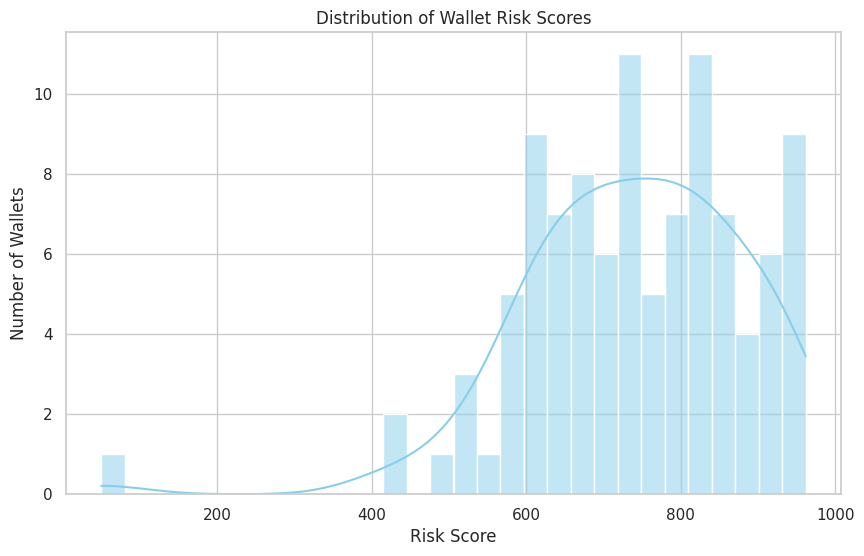

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set(style="whitegrid")

# Plot distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['score'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Wallet Risk Scores')
plt.xlabel('Risk Score')
plt.ylabel('Number of Wallets')
plt.show()


# **Top 10 Highest Risk Wallets**

In [15]:
# Sort by highest score (most risky)
top_risk_wallets = df.sort_values(by='score', ascending=False).head(10)
print("Top 10 Highest Risk Wallets")
print(top_risk_wallets)


Top 10 Highest Risk Wallets
                                         wallet  total_supplied_usd  \
2    0x0795732aacc448030ef374374eaae57d2965c16c             9413.08   
72   0x9ba0d85f71e145ccf15225e59631e5a883d5d74a             9645.12   
56   0x7e3eab408b9c76a13305ef34606f17c16f7b33cc             9417.89   
51   0x7851bdfb64bbecfb40c030d722a1f147dff5db6a             8486.88   
76   0xa98dc64bb42575efec7d1e4560c029231ce5da51             8849.50   
77   0xb271ff7090b39028eb6e711c3f89a3453d5861ee             9626.89   
81   0xc179d55f7e00e789915760f7d260a1bf6285278b             8045.05   
96   0xf340b9f2098f80b86fbc5ede586c319473aa11f3             8163.22   
45   0x6d69ca3711e504658977367e13c300ab198379f1             9332.79   
100  0xf7aa5d0752cfcd41b0a5945867d619a80c405e52             9624.87   

     total_borrowed_usd  reputation_score  utilization_rate  supplied_score  \
2               2675.34                93          0.284215        0.947003   
72              3301.67         

# **Top 10 Lowest Risk Wallets**

In [16]:
# Sort by lowest score (least risky)
low_risk_wallets = df.sort_values(by='score', ascending=True).head(10)
print("Top 10 Lowest Risk Wallets")
print(low_risk_wallets)


Top 10 Lowest Risk Wallets
                                        wallet  total_supplied_usd  \
87  0xd1a3888fd8f490367c6104e10b4154427c02dd9c              240.74   
71  0x9ad1331c5b6c5a641acffb32719c66a80c6e1a17              873.95   
67  0x93f0891bf71d8abed78e0de0885bd26355bb8b1d              233.75   
13  0x1c1b30ca93ef57452d53885d97a74f61daf2bf4f              767.25   
1   0x06b51c6882b27cb05e712185531c1f74996dd988              823.82   
21  0x330513970efd9e8dd606275fb4c50378989b3204              722.94   
27  0x4814be124d7fe3b240eb46061f7ddfab468fe122              621.11   
49  0x7399dbeebe2f88bc6ac4e3fd7ddb836a4bce322f             1769.56   
88  0xd334d18fa6bada9a10f361bae42a019ce88a3c33             2744.58   
92  0xded1f838ae6aa5fcd0f13481b37ee88e5bdccb3d              986.88   

    total_borrowed_usd  reputation_score  utilization_rate  supplied_score  \
87             4564.14                25         18.958794        0.000721   
71             4376.70                14      

# **Save Excel File**

In [17]:
output_df.to_excel("wallet_risk_scores.xlsx", index=False)
print("Saved to wallet_risk_scores.xlsx")

Saved to wallet_risk_scores.xlsx


**Reasoning**:
Select and scale the relevant features for clustering.



Unsupervised Validation: Since we don’t have labeled "risky" vs. "safe" wallet data, clustering allows us to group similar wallets and observe emergent patterns.

Data-Driven Grouping: Clustering helps verify if wallets with similar feature behaviors fall into similar risk score ranges.

Anomaly Detection: Clusters with high borrow and low repay/mint activity can act as early warning groups.

Interpretability: Helps explain and potentially refine the scoring logic by analyzing the characteristics of each cluster

In [18]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

features_for_clustering = ['total_supplied_usd', 'total_borrowed_usd', 'utilization_rate', 'reputation_score']
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(df[features_for_clustering])

**Reasoning**:
Apply K-Means clustering to the scaled features and add the cluster labels to the dataframe.

In [19]:
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10) # n_init=10 to suppress warning
df['cluster_label'] = kmeans.fit_predict(scaled_features)

**Reasoning**:
Analyze the relationship between the cluster labels and the calculated risk scores by grouping by cluster and calculating the mean score for each cluster.

In [20]:
cluster_score_analysis = df.groupby('cluster_label')['score'].mean().sort_values()
print("Mean Risk Score per Cluster:")
print(cluster_score_analysis)

Mean Risk Score per Cluster:
cluster_label
3    568.722222
2    670.541667
0    734.111111
1    879.588235
Name: score, dtype: float64


**Reasoning**:
Visualize the clusters in relation to the risk score using a scatter plot to further assess the alignment.

In [23]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Define features for clustering
features_for_clustering = ['total_supplied_usd', 'total_borrowed_usd', 'utilization_rate', 'reputation_score']

# Normalize features again using StandardScaler (better for KMeans)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[features_for_clustering])

# Apply KMeans
kmeans = KMeans(n_clusters=3, random_state=42)
df['cluster'] = kmeans.fit_predict(X_scaled)

In [24]:
df['cluster']

,cluster
0,1
1,2
2,0
3,2
4,0
...,...
98,1
99,1
100,0
101,0


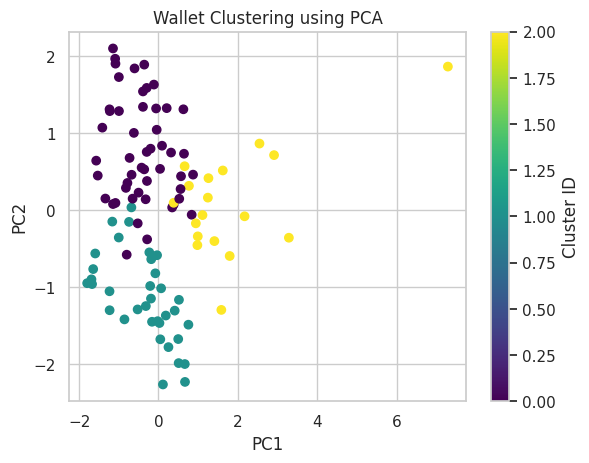

In [25]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
components = pca.fit_transform(X_scaled)

plt.scatter(components[:, 0], components[:, 1], c=df['cluster'], cmap='viridis')
plt.title("Wallet Clustering using PCA")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(label='Cluster ID')
plt.show()